In [1]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.stats import norm

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')

In [2]:
# Load results from .pkl:
output_dir = '../../../../../../data/Helpdesk/conformal_val_without_dropout/conformal_conformance_results'

filename = os.path.join(output_dir, 'results.pkl')
with open(filename, 'rb') as f:
    loaded_results = pickle.load(f)

qs_per_prefix_length = loaded_results["qs_per_prefix_length"]
mean_tgts_per_prefix_length = loaded_results["mean_tgts_per_prefix_length"]
mean_ml_per_prefix_length = loaded_results["mean_ml_per_prefix_length"]
mean_samples_per_prefix_length = loaded_results["mean_samples_per_prefix_length"]

print(f"Loaded data from {filename}")

Loaded data from ../../../../../../data/Helpdesk/conformal_val_without_dropout/conformal_conformance_results/results.pkl


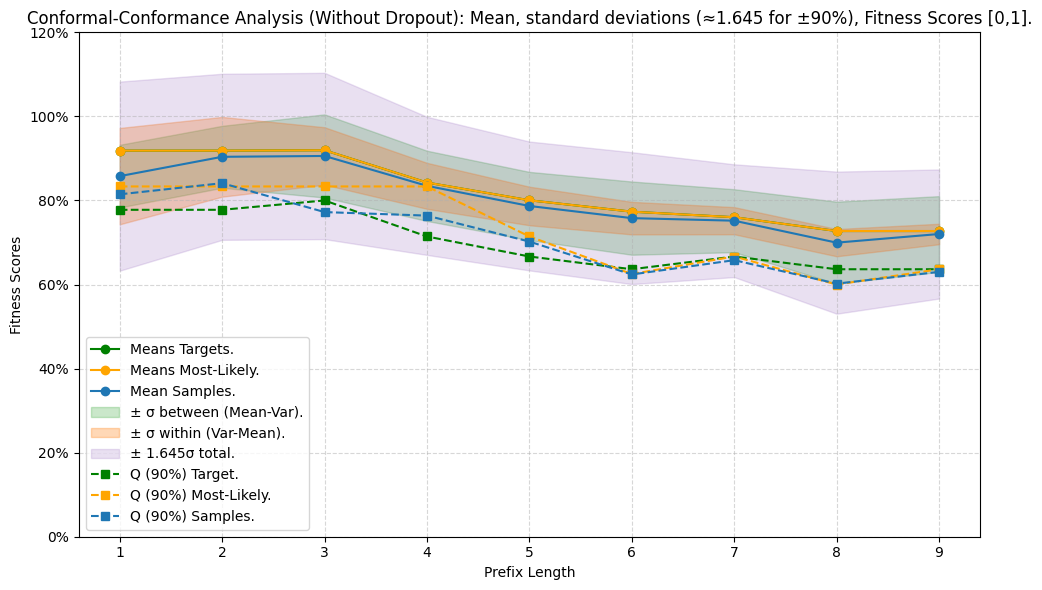

In [3]:
alpha = 0.1

prefix_lengths = []

q_tgts = []
q_mls = []
q_samples = []

means_tgts = []
means_mls = []

means_sms = []
vars_means_sms = []
means_vars_sms = []

for d_q, d_mean_tgt, d_mean_ml, d_mean_var_sms in zip(qs_per_prefix_length, mean_tgts_per_prefix_length, mean_ml_per_prefix_length, mean_samples_per_prefix_length):
    # Get prefix length
    prefix_len = next(iter(d_q)) 
    prefix_lengths.append(prefix_len)
    
    # Get Q threshold for targte, most likely, samples for prefix length
    q_tgt, q_ml, q_sm = d_q[prefix_len]
    q_tgts.append(q_tgt)
    q_mls.append(q_ml)
    q_samples.append(q_sm)
    
    # Get Mean fitness score of target
    means_tgts.append(d_mean_tgt[prefix_len])
    
    # Get Mean fitness score of most-likely
    means_mls.append(d_mean_ml[prefix_len])
    
    # Get Mean fitness value of all mean fitness values, 1) The variacne of the mean fitness scores, 2) The mean of the variances for each fitness score over all mean fitness scores, per prefix length.
    mean, (var_mean, mean_var) = d_mean_var_sms[prefix_len]
    means_sms.append(mean)
    # Varaince between mean fitness values
    vars_means_sms.append(var_mean)
    # Mean within 
    means_vars_sms.append(mean_var)
    
# Sort by prefix (normally already sorted) length and transform to numpy array.
idx = np.argsort(prefix_lengths)

prefix_lengths = np.array(prefix_lengths)[idx]

q_tgt = np.array(q_tgts)[idx]
q_mls = np.array(q_mls)[idx]
q_samples = np.array(q_samples)[idx]

means_sms = np.array(means_sms)[idx]
vars_means_sms   = np.array(vars_means_sms)[idx]
means_vars_sms   = np.array(means_vars_sms)[idx]

# Compute standard deviations
sd_vars_means = np.sqrt(vars_means_sms)
sd_means_vars = np.sqrt(means_vars_sms)    
std_total   = np.sqrt(vars_means_sms + means_vars_sms)    

# Build Bounds
# between-band
lower_between = means_sms - sd_vars_means
upper_between = means_sms + sd_vars_means

# within-band
lower_within = means_sms - sd_means_vars
upper_within = means_sms + sd_means_vars

# Get two-side 1-alpha/2-intervall by using alpha/2:
z90 = norm.ppf(1 - alpha/2) # ≈1.645 for ±90%

# total 95% band
lower_total95 = means_sms - z90 * std_total
upper_total95 = means_sms + z90 * std_total

# Plot
plt.figure(figsize=(10, 6))

# Mean lines
plt.plot(prefix_lengths, means_mls, marker='o', label='Means Targets.', color='green')
plt.plot(prefix_lengths, means_mls, marker='o', label='Means Most-Likely.', color='orange')
plt.plot(prefix_lengths, means_sms, marker='o', label='Mean Samples.', color='C0')

# Between‐batch ±1σ
plt.fill_between(prefix_lengths,
                 lower_between, 
                 upper_between,
                 alpha=0.25, color='C2', label='± σ between (Mean-Var).')

# Within‐batch ±1σ
plt.fill_between(prefix_lengths,
                 lower_within, 
                 upper_within,
                 alpha=0.3, color='C1', label='± σ within (Var-Mean).')

# Total ±1.96σ (≈95% coverage)
plt.fill_between(prefix_lengths,
                 lower_total95, 
                 upper_total95,
                 alpha=0.2, color='C4', label='± 1.645σ total.')

# Q₀.₉ threshold
plt.plot(prefix_lengths, q_tgts, marker='s', linestyle='--', color='green', label='Q (90%) Target.')
plt.plot(prefix_lengths, q_mls, marker='s', linestyle='--', color='orange', label='Q (90%) Most-Likely.')
plt.plot(prefix_lengths, q_samples, marker='s', linestyle='--', color='C0', label='Q (90%) Samples.')

# 6. Polish
plt.xlabel('Prefix Length')
plt.ylabel('Fitness Scores')
plt.ylim(0, 1.2)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Conformal-Conformance Analysis (Without Dropout): Mean, standard deviations (≈1.645 for ±90%), Fitness Scores [0,1].')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


In [4]:
for i in range(len(qs_per_prefix_length)):
    
    print('Prefix length: ', list(qs_per_prefix_length[i].keys())[0])
    
    print('Target q (0.9 coverage): ', list(qs_per_prefix_length[i].values())[0][0])
    print('Most likely q (0.9 coverage): ', list(qs_per_prefix_length[i].values())[0][1])
    print('Samples means q (0.9 coverage): ', list(qs_per_prefix_length[i].values())[0][2])
    
    print('Target mean means: ', list(mean_tgts_per_prefix_length[i].values())[0])
    
    print('Most-Likely mean means: ', list(mean_ml_per_prefix_length[i].values())[0])
    
    print('Samples mean means: ', list(mean_samples_per_prefix_length[i].values())[0][0])
    print('Samples mean variances: ', list(mean_samples_per_prefix_length[i].values())[0][1])
    

Prefix length:  1
Target q (0.9 coverage):  0.7777777777777778
Most likely q (0.9 coverage):  0.8333333333333334
Samples means q (0.9 coverage):  0.8146014346764348
Target mean means:  0.9468783068783069
Most-Likely mean means:  0.9185150446261559
Samples mean means:  0.8578776285922584
Samples mean variances:  (np.float64(0.005555486780311199), np.float64(0.013139594299400958))
Prefix length:  2
Target q (0.9 coverage):  0.7777777777777778
Most likely q (0.9 coverage):  0.8333333333333334
Samples means q (0.9 coverage):  0.8411161616161617
Target mean means:  0.9548148148148149
Most-Likely mean means:  0.9185150446261559
Samples mean means:  0.9038753253193994
Samples mean variances:  (np.float64(0.0054283685173291355), np.float64(0.00899738810271392))
Prefix length:  3
Target q (0.9 coverage):  0.8
Most likely q (0.9 coverage):  0.8333333333333334
Samples means q (0.9 coverage):  0.7723368326118326
Target mean means:  0.9394619666048238
Most-Likely mean means:  0.9194768651262157
Sam